In [65]:
import random
import matplotlib.pyplot as plt
import networkx as nx

**The Plan**
- Define a super simple MDP. Start without any cycles, literally just make it a directed acyclic graph.
- Assign random numbers to all state-action pairs in this MDP (e.g. sampled from a gaussian with mean 0, variance 1), i.e. a maximally dense reward function.
- Write a function which computes the set of optimal policies assuming that those numbers are interpreted as a reward function.
- Generate many (e.g. 1000) random reward functions, and check that the optimal policies they lead to are non-uniform, i.e. some policies are more likely than others to be generated via this process.

Hypotheses: (speculative)
- Some policies will be more likely than others to be generated (what structure in particular?)

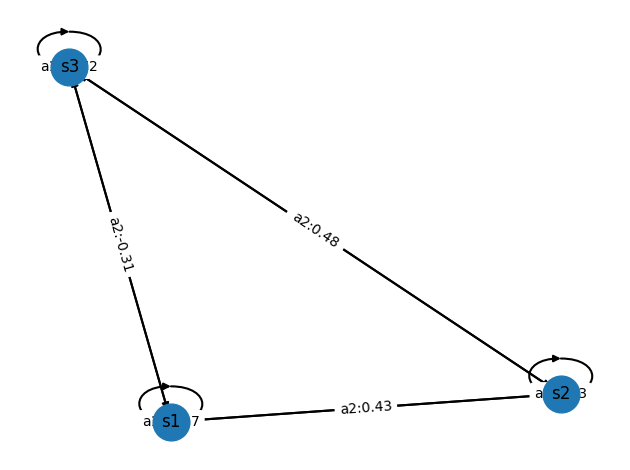

MDP Summary:
States: s1, s2, s3
Actions: a1, a2
Discount Factor: 0.9
Optimal Policy: {'s1': 'a2', 's2': 'a1', 's3': 'a2'}


In [66]:
### Defining a markov decision process
### Thanks ChatGPT (again)

import numpy as np

class MDP:
    def __init__(self, states, actions, transition_function, reward_function, gamma):
        self.states = states
        self.actions = actions
        self.transition_function = transition_function  # Function: (s, a, s') -> Probability
        self.reward_function = reward_function  # Function: (s, a, s') -> Reward, now passed during initialization
        self.gamma = gamma

    def get_possible_actions(self, state):
        return self.actions

    def transition(self, state, action):
        return [(self.transition_function(state, action, next_state),
                 next_state,
                 self.reward_function(state, action, next_state))
                for next_state in self.states]

    def compute_optimal_policy(self, epsilon=0.01, max_iterations=1000):
        # Initialize the value function for each state to zero
        values = {state: 0 for state in self.states}
        # Initialize the policy for each state to None
        policy = {state: None for state in self.states}

        # Repeat until convergence or maximum iterations reached
        for _ in range(max_iterations):
            # Keep track of the maximum change in the value function across all states
            delta = 0

            # Update the value function for each state
            for state in self.states:
                # Store the current value function for the state
                v = values[state]

                # Calculate the value for all possible actions from the current state
                action_values = [
                    sum(p * (reward + self.gamma * values[next_state])
                        for p, next_state, reward in self.transition(state, action))
                    for action in self.get_possible_actions(state)
                ]

                # Update the value function to the maximum value across all actions
                values[state] = max(action_values)

                # Update delta to the maximum change in the value function
                delta = max(delta, abs(v - values[state]))

            # If the maximum change in the value function is less than epsilon, we've converged
            if delta < epsilon:
                break

        # After the value function has converged, determine the optimal policy
        for state in self.states:
            # Calculate the expected value of each action using the converged value function
            action_values = {
                action: sum(p * (reward + self.gamma * values[next_state])
                            for p, next_state, reward in self.transition(state, action))
                for action in self.get_possible_actions(state)
            }

            # Select the action that has the highest expected value
            policy[state] = max(action_values, key=action_values.get)

        # Return the optimal policy and the converged value function
        return policy

    def plot_graph(self):
        G = nx.MultiDiGraph()

        # Add nodes for each state
        for state in self.states:
            G.add_node(state)

        # Add edges for each action and transition
        for state in self.states:
            for action in self.actions:
                for next_state in self.states:
                    if self.transition_function(state, action, next_state) > 0:
                        reward = self.reward_function(state, action, next_state)
                        G.add_edge(state, next_state, action=action, weight=reward)

        # plt.figure(figsize=(12, 8))  # Increase the plot size
        pos = nx.spring_layout(G, k=0.5, iterations=20)  # k: Optimal distance between nodes. Increase/decrease to spread nodes out

        nx.draw_networkx_nodes(G, pos, node_size=700)
        nx.draw_networkx_labels(G, pos)

        # Draw edges and add labels
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1.5)

        edge_labels = {(u, v): f"{d['action']}:{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
        
        # Calculate edge label positions at the midpoint of the edges
        edge_label_pos = {edge: ((pos[edge[0]][0] + pos[edge[1]][0]) / 2, (pos[edge[0]][1] + pos[edge[1]][1]) / 2) 
                        for edge in G.edges()}

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        plt.axis('off')
        plt.tight_layout()  # Adjust layout to prevent cutting off edge labels
        plt.show()

    def __str__(self):
        states_str = ', '.join(self.states)
        actions_str = ', '.join(self.actions)
        return (f"MDP Summary:\n"
                f"States: {states_str}\n"
                f"Actions: {actions_str}\n"
                f"Discount Factor: {self.gamma}")


# Define a reward function that assigns random rewards for each state-action pair
def random_reward_function(states, actions):
    """Initializes a reward function that assigns random rewards to state-action pairs."""
    rewards = {}
    for state in states:
        for action in actions:
            for next_state in states:
                rewards[(state, action, next_state)] = np.random.normal(0, 1)  # Gaussian distribution, mean=0, variance=1
    # print(rewards)
    return lambda s, a, s_prime: rewards[(s, a, s_prime)]

# Example MDP setup
states = ['s1', 's2', 's3']
actions = ['a1', 'a2']
def transition_function(s, a, s_prime): #simple function for demonstration
    if a == actions[0]:
        return 1 if s_prime == s else 0
    else:
        return 0 if s_prime == s else (1.0 / len(states))

gamma = 0.9 # Discount factor
# Create an MDP object with the randomized reward function

mdp = MDP(states, actions, transition_function, random_reward_function(states, actions), gamma)
optimal_policy = mdp.compute_optimal_policy()
mdp.plot_graph()
print(mdp)
print("Optimal Policy:", optimal_policy)

In [67]:
### Oops, there's already a function for this in the mdptoolbox library
import mdptoolbox, mdptoolbox.example
import numpy as np

# Generate a simple example MDP problem
P, R = mdptoolbox.example.forest(S=3, r1=4, r2=2, p=0.1)

# P is the transition probability matrix
# P[action][state, nextState] = probability of transitioning from state to nextState given action
# R is the reward matrix
# R[state, action] = reward received when taking action in state

# Initialize the Value Iteration algorithm
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)

# Run the Value Iteration algorithm
vi.run()

# Output results
print("Policy:", vi.policy)  # Best action in each state
print("Value:", vi.V)  # Value of each state


Policy: (0, 0, 0)
Value: (5.051970000000001, 8.291970000000001, 12.291970000000001)


In [68]:
### Test 1000 reward functions, see what policies we get

NUM_REWARD_FUNCTIONS = 1000
states = ['s1', 's2', 's3']
actions = ['a1', 'a2']
gamma = 0.9
def test_randomness(states, actions, gamma):
    random_reward_functions = [random_reward_function(states, actions) for _ in range(NUM_REWARD_FUNCTIONS)]

    mdps = [MDP(states, actions, transition_function, reward_function, gamma) for reward_function in random_reward_functions]
    optimal_policies = [mdp.compute_optimal_policy() for mdp in mdps]
    # optimal_policies = [mdp.compute_optimal_policy() for mdp in ([mdps[0]] * 1000)] 
    # ^ debug to make sure compute_optimal_policy is deterministic
    # print("Optimal Policies:", optimal_policies)

    opt_pol_counts = {}
    for policy in optimal_policies:
        key = str(policy)
        if key in opt_pol_counts:
            opt_pol_counts[key] += 1
        else:
            opt_pol_counts[key] = 1
    print("Optimal Policy Counts:", opt_pol_counts.values())
    return opt_pol_counts

pol_counts = {}
for _ in range(10):
    entry = test_randomness(states, actions, gamma)
    for k in entry.keys():
        if k in pol_counts:
            pol_counts[k] += entry[k]
        else:
            pol_counts[k] = entry[k]
pol_counts

Optimal Policy Counts: dict_values([88, 94, 139, 199, 208, 182, 68, 22])
Optimal Policy Counts: dict_values([198, 181, 142, 71, 79, 198, 103, 28])
Optimal Policy Counts: dict_values([208, 204, 133, 93, 181, 78, 85, 18])
Optimal Policy Counts: dict_values([218, 187, 188, 80, 104, 127, 11, 85])
Optimal Policy Counts: dict_values([134, 82, 197, 196, 78, 85, 209, 19])
Optimal Policy Counts: dict_values([90, 99, 226, 186, 119, 184, 72, 24])
Optimal Policy Counts: dict_values([72, 197, 138, 83, 16, 200, 200, 94])
Optimal Policy Counts: dict_values([88, 186, 222, 192, 88, 78, 125, 21])
Optimal Policy Counts: dict_values([200, 189, 82, 82, 87, 27, 210, 123])
Optimal Policy Counts: dict_values([192, 89, 115, 80, 218, 210, 16, 80])


{"{'s1': 'a1', 's2': 'a2', 's3': 'a1'}": 892,
 "{'s1': 'a1', 's2': 'a1', 's3': 'a2'}": 813,
 "{'s1': 'a2', 's2': 'a2', 's3': 'a2'}": 1295,
 "{'s1': 'a1', 's2': 'a2', 's3': 'a2'}": 1963,
 "{'s1': 'a2', 's2': 'a1', 's3': 'a2'}": 1942,
 "{'s1': 'a2', 's2': 'a2', 's3': 'a1'}": 2061,
 "{'s1': 'a2', 's2': 'a1', 's3': 'a1'}": 832,
 "{'s1': 'a1', 's2': 'a1', 's3': 'a1'}": 202}

In [69]:
### Chi-squared test for optimal policy counts (null hypothesis: all policies are equally likely)
from scipy.stats import chisquare

NUM_REWARD_FUNCTIONS = 10**3
def chi_squared_test(opt_pol_counts):
    expected = [NUM_REWARD_FUNCTIONS / len(opt_pol_counts)] * len(opt_pol_counts)
    chi2, p = chisquare(list(opt_pol_counts.values()), f_exp=expected)
    print(f"Chi-squared: {chi2}, p-value: {p}")

for _ in range(10):
    chi_squared_test(test_randomness(states, actions, gamma))

Optimal Policy Counts: dict_values([204, 89, 92, 185, 130, 199, 90, 11])
Chi-squared: 255.584, p-value: 1.7940510385638923e-51
Optimal Policy Counts: dict_values([209, 123, 212, 17, 202, 80, 87, 70])
Chi-squared: 309.728, p-value: 5.055234185920587e-63
Optimal Policy Counts: dict_values([200, 132, 83, 208, 85, 177, 92, 23])
Chi-squared: 240.99200000000002, p-value: 2.2863155066284512e-48
Optimal Policy Counts: dict_values([198, 198, 98, 205, 92, 124, 69, 16])
Chi-squared: 271.152, p-value: 8.649576517095512e-55
Optimal Policy Counts: dict_values([217, 133, 80, 195, 88, 194, 75, 18])
Chi-squared: 284.25600000000003, p-value: 1.3879346391187285e-57
Optimal Policy Counts: dict_values([215, 75, 138, 195, 186, 91, 70, 30])
Chi-squared: 260.76800000000003, p-value: 1.411807722664228e-52
Optimal Policy Counts: dict_values([198, 189, 216, 82, 91, 135, 16, 73])
Chi-squared: 283.168, p-value: 2.3685960258412134e-57
Optimal Policy Counts: dict_values([205, 204, 77, 196, 98, 120, 84, 16])
Chi-squa

In [70]:
### Sparse reward function test

def sparse_reward_function(states, actions, sparsity = 0.9):
    rewards = {}
    for state in states:
        for action in actions:
            for next_state in states:
                rewards[(state, action, next_state)] = 0 if random.random() < sparsity else np.random.normal(0, 1)
    return lambda s, a, s_prime: rewards[(s, a, s_prime)]

def test_sparsity(states, actions, gamma, sparsity = 0.9):
    random_reward_functions = [sparse_reward_function(states, actions, sparsity) for _ in range(NUM_REWARD_FUNCTIONS)]

    mdps = [MDP(states, actions, transition_function, reward_function, gamma) for reward_function in random_reward_functions]
    optimal_policies = [mdp.compute_optimal_policy() for mdp in mdps]

    opt_pol_counts = {}
    for policy in optimal_policies:
        key = str(policy)
        if key in opt_pol_counts:
            opt_pol_counts[key] += 1
        else:
            opt_pol_counts[key] = 1
    print("Optimal Policy Counts:", opt_pol_counts)
    return opt_pol_counts

for i in [0.1, 0.5, 0.9, 0.99, 0.999, 0.9999]:
    test_sparsity(states, actions, gamma, i)

Optimal Policy Counts: {"{'s1': 'a1', 's2': 'a2', 's3': 'a1'}": 61, "{'s1': 'a2', 's2': 'a2', 's3': 'a1'}": 244, "{'s1': 'a1', 's2': 'a1', 's3': 'a1'}": 9, "{'s1': 'a1', 's2': 'a2', 's3': 'a2'}": 202, "{'s1': 'a2', 's2': 'a1', 's3': 'a1'}": 83, "{'s1': 'a2', 's2': 'a2', 's3': 'a2'}": 123, "{'s1': 'a2', 's2': 'a1', 's3': 'a2'}": 209, "{'s1': 'a1', 's2': 'a1', 's3': 'a2'}": 69}
Optimal Policy Counts: {"{'s1': 'a2', 's2': 'a1', 's3': 'a2'}": 215, "{'s1': 'a1', 's2': 'a2', 's3': 'a2'}": 208, "{'s1': 'a1', 's2': 'a1', 's3': 'a2'}": 62, "{'s1': 'a2', 's2': 'a2', 's3': 'a1'}": 195, "{'s1': 'a1', 's2': 'a2', 's3': 'a1'}": 52, "{'s1': 'a2', 's2': 'a2', 's3': 'a2'}": 187, "{'s1': 'a1', 's2': 'a1', 's3': 'a1'}": 38, "{'s1': 'a2', 's2': 'a1', 's3': 'a1'}": 43}
Optimal Policy Counts: {"{'s1': 'a2', 's2': 'a2', 's3': 'a2'}": 180, "{'s1': 'a1', 's2': 'a1', 's3': 'a1'}": 558, "{'s1': 'a1', 's2': 'a2', 's3': 'a2'}": 68, "{'s1': 'a1', 's2': 'a2', 's3': 'a1'}": 33, "{'s1': 'a2', 's2': 'a2', 's3': 'a1'}":